# Preprocessing & individual level statistics

Hereinafter, we will provide the code and steps conducted during the preprocessing and individual level statistical analyses". Please note, that due to an absent consent of the participants, this page provides the code but you can't rerun the analyses on the raw data (as mentioned [here]()).   
The following steps were run:

* [structural preprocessing]()   
* [functional preprocessing]()  
* [individual level statistics]()  
* [native space - template space coregistration]()  
* [native to template space transformation]()

The respective sections contain further information regarding the specifics and implementation. Let's start the adventure with structural preprocessing.

## Structural preprocessing

The first step of our preprocessing consisted of a comprehensive structural processing pipeline called [Mindboggle](https://mindboggle.info/). It's aim is to extract a multitude of so called `shape features` that describe cortical gray matter parts of the brain through volume and surface based characteristics. This entails: `volume`, `thickness`, `curvature`, `travel depth`, etc. and is obtained for each ROI in the [Mindboggle DKT atlas](https://mindboggle.info/data.html). To this end, `mindboggle` combines [FreeSurfer's recon-all](https://surfer.nmr.mgh.harvard.edu/fswiki/FreeSurferAnalysisPipelineOverview), [ANTs antsCorticalThickness](https://pubmed.ncbi.nlm.nih.gov/19150502/) and [mindboggle itself](https://mindboggle.readthedocs.io/en/latest/#id7) via [nipype](https://nipype.readthedocs.io/en/latest/). For this project we utilized exclusively the [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) output, while the other outputs will be used in subsequent studies. Thus, we don't go into further details here, but point interested readers to the [original `mindboggle` publication](https://dx.doi.org/10.1371/journal.pcbi.1005350) and the [`mindboggle` website](https://mindboggle.info/). As `mindboggle` is intended to run as a [BIDS app](http://bids-apps.neuroimaging.io/) and because it's a great idea in general, we used the [mindboggle docker image](https://hub.docker.com/r/nipy/mindboggle) to process the structural images. As you can see below, we simply defined the required directories on our `host machine` and within the `docker image`, as well as a list of `participants` to process. Then, we set up a small for loop that applies the `mindboggle123` pipeline for a given participant. Please note, that this part is run within the `bash shell` and not `python` as we need to run `docker`. 

In [ ]:
%%bash 

HOST=/data/mvs/
DOCK=/home/jovyan/work

declare -a participants=("sub-01" "sub-02" "sub-03" "sub-04" "sub-05" "sub-06" "sub-07" "sub-08" "sub-09" "sub-10" "sub-11" "sub-12" "sub-13" "sub-14" "sub-15" "sub-16" "sub-17" "sub-18" "sub-19" "sub-20" "sub-21" "sub-22" "sub-23" "sub-24")

for part in "${participants[@]}"
do 

    IMAGE=/home/jovyan/work/$part/anat/$part"_T1w.nii.gz"
    ID=$part

    docker run --rm -ti -v $HOST:$DOCK nipy/mindboggle mindboggle123 $IMAGE --id $ID

done

After a good while (geez, a gooooood while), we'll have our outputs under `/data/mvs/derivatives/mindboggle`. Within this folder, three subdirectories can be found, corresponding to the included pipelines `mindboggle` combines: `FreeSurfer`, `ANTs` and `mindboggle`. As said before, we will only use `FreeSurfer` output hereinafter. Thanks to [BIDS](https://bids.neuroimaging.io/) and the great community behind it, this first part of the preprocessing was a no-brainer and super straightforward. The subsequent coregistration of the `anatomical images` and `template image` was a bit more work, but still feasible given `nipype`. We will check that next.

## Functional preprocessing

The preprocessing of the functional images was roughly divided into two sections: classic preprocessing steps and mask generation. The corresponding steps and functions were conducted in various software packages, including [SPM](https://www.fil.ion.ucl.ac.uk/spm/), [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/) and [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) and implemented, connected and run via [nipype](https://nipype.readthedocs.io/en/latest/). The "classic" preprocessing entailed realignment (through [SPM's Realign](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.preprocess.html#realign)), coregistration (through [FreeSurfer's BBRegister](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.freesurfer.preprocess.html#bbregister)) and spatial smoothing (through [SPM's Smooth](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.preprocess.html#smooth)).  The mask creation part contained the creation of participant specific masks aimed to restrict the subsequent statistical analyses to cortical gray matter voxels. First, we used [FreeSurfer's Binarize](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.freesurfer.model.html#binarize) to extract and combine cortical gray matter voxels belonging to either the left or right hemisphere from [FreeSurfer's aparc+aseg volume](https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation) (which we obtained within the structural processing) and binarized the resulting image. Next, we transformed this image to a given participant's functional space by using the computed coregistration matrix within [FreeSurfer's ApplyVolTransform](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.freesurfer.preprocess.html#applyvoltransform). Subquently, we used [FSL's ImageMaths](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.utils.html#imagemaths) to substract the transformed cortical gray matter mask from the mean functional image (obtained through the `realign` step) which yielded a mask in a given participant's functional space that was covered by the data acquisition protocols `FoV` and restricted to gray matter. In the last step, the resulting mask was dilated by one voxel and binarized (both via [FreeSurfer's Binarize](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.freesurfer.model.html#binarize)). Hereinafter we show how this was set up, including important paths and variables, necessary nodes and workflow definition. However, as usual we start with the important of the recquired modules and functions.       

### Import modules
As mentioned before, we'll use the `nipype` implementation of the respective functions to allow for easy and reproducible execution. 

In [ ]:
from os.path import join as opj
from nipype.interfaces.freesurfer import (BBRegister, ApplyVolTransform,
                                          Binarize, MRIConvert, FSCommand)
from nipype.interfaces.fsl import BET, BinaryMaths, ImageMaths
from nipype.interfaces.spm import (Realign, Smooth, SPMCommand)
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import FreeSurferSource, SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.algorithms.misc import Gunzip
from nipype.pipeline import Node, MapNode, Workflow

### Define and set important paths and variables
At first, we need to define a few important paths and variables that are needed for various aspects of the workflow. For example, we need to tell `nipype` where our `SPM` installation is. Notably, we set up the [standalone version](https://en.wikibooks.org/wiki/SPM/Standalone) which doesn't require `MATLAB` as it can run via its [compiler runtime](https://www.mathworks.com/help/compiler/install-the-matlab-runtime.html).

In [ ]:
matlab_cmd = '/usr/local/spm12/run_spm12.sh /usr/local/MATLAB/MATLAB_Compiler_Runtime/v713/' 
SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

We also need to set the data directory and list of participants to process:

In [ ]:
experiment_dir = '/data/mvs/' 
data_dir= experiment_dir

participant_list = [] 

for i in range(1,24): 
    if i < 10: 
        participant_list.append('sub-0%s' %i) 
    else: 
        participant_list.append('sub-%s' %i)

We're only missing the output and working directory of the workflow: 

In [ ]:
output_dir = '/data/mvs/derivatives/preprocessing' 
working_dir = '/data/mvs/derivatives/preprocessing/workingdir_preprocessing' 

Now that we have that, we can define our workflow nodes:

### Define and set processing nodes
We need to set up one node for each of the above mentioned functions. Within that, we can additionally specify certain aspects of how the respective functions should run. Initially, we actually need a utility function to `unzip` our functional images as `SPM` can't read zipped files. The [Gunzip function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.algorithms.misc.html#gunzip) allows us to do that: 

In [ ]:
gunzip = MapNode(Gunzip(), name="gunzip", iterfield=['in_file'])

Next, the unzipped files should be realigned through [SPM's Realign](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.preprocess.html#realign). Here, we set the parameter `register_to_mean` to `True` as we want to apply a two-step realignment procedure. This means that  the first image of the second run was realigned to the first image of the first run and subsequently all images of a given run were realigned to the first image of their respective run. 

In [ ]:
realign = Node(Realign(register_to_mean=True),
               name="realign")

The coregistration of a participant's functional and structural space was computed via [FreeSurfer's BBRegister](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.freesurfer.preprocess.html#bbregister
) and set up to use an `SPM affine initiation` and an optimization for `T2w` images. 

In [ ]:
bbregister = Node(BBRegister(init='spm',
                             contrast_type='t2',
                             out_fsl_file=True),
                  name='bbregister')

Functional images were spatially smoothed with a 6mm FHWM Gaussian Kernel using [SPM's Smooth](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.preprocess.html#smooth).

In [ ]:
smooth = Node(Smooth(fwhm=6),
              name="smooth")

Through [FreeSurfer's Binarize function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.freesurfer.model.html#binarize) labels corresponding cortical gray matter in the left and right hemisphere were extracted from each participant's [aparc+aseg volume](https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation) obtained through [recon-all](https://surfer.nmr.mgh.harvard.edu/fswiki/FreeSurferAnalysisPipelineOverview) running as part of [mindboggle](https://mindboggle.info/). As you can see, this refers to label `3` and `42`. 

In [ ]:
binarizeCortical = Node(Binarize(out_type='nii.gz',
                                    match = [3,42],
                                    binary_file='binarized_cortical_gm.nii.gz'),
                        name='binarizeCortical')

The resulting binary mask needs to be transformed into a given participant's native space. We can do that with [FreeSurfer's ApplyVolTransform](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.freesurfer.preprocess.html#applyvoltransform), setting the `interpolation` method to `nearest`.

In [ ]:
applyVolTrans_cortical_mask = Node(ApplyVolTransform(
                                  interp='nearest'),
                name='applyVolTrans_cortical_mask')

Now that the structural cortical gray matter mask is in functional space, we need to create a binary mask from the functional images to build their intersection. As we will get the mean functional image through the `realign` step, we can use [FSL's BET](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.preprocess.html#bet) to compute a binary mask from it while restricting our image to cortical voxels only. Thus, we specify `mask=True` within the function definition and additionally set `robust` to `true` in order to run multiple iterations of the mask extraction, enhancing the fit of our results. Regarding fit we also set the `frac` parameter, here to a value of `0.55`, which defines the strictness of the extraction.  

In [ ]:
meanfuncmask = Node(interface=BET(mask=True,
                                  no_output=False,
                                  frac=0.55,
                                  robust=True,
                                  output_type='NIFTI',
                                  out_file='meanfunc'),
                       name='meanfuncmask')

With that we have both, a structural cortical gray matter mask and a functional cortical mask, in the same space and can subtract them from one another to build their intersection. The result will be a mask in a given participant's functional space that was covered by the data acquisition protocols FoV and restricted to gray matter. We can achieve this via [FSL's ImageMaths](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.utils.html#imagemaths) defining the operation (`op_string`) as `-mas`. Note that we set it up as a [MapNode](https://miykael.github.io/nipype_tutorial/notebooks/basic_mapnodes.html) and defining the `in_file` as the `iterfield`, thus enabling multiple `input files`.  

In [ ]:
subtract_cortical_gm_func = MapNode(interface=ImageMaths(op_string='-mas', 
                                                    output_type='NIFTI', 
                                                    out_file='cortical_gm_func_mask.nii'),
                                    iterfield=['in_file'],
                                    name='subtract_cortical_gm_func')

As there's always some uncertainty when it comes to segmentation, extraction and transformation, we're going to dilate the resulting mask by one voxel and binarize it again. Here, [FreeSurfer's Binarize](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.freesurfer.model.html#binarize) comes in handy again.

In [ ]:
dilate_binarize_mask = Node(Binarize(dilate=1,
                          min=0.5),
              name='dilate_binarize_mask')

That's it, all necessary processing nodes are set and defined. Now we need to create a workflow and connect them.

### Create the workflow and connect nodes

In order to connect our processing nodes and run them as a workflow, we need to create the basis via defining an empty workflow and setting the base directory within which the processing will occur. In our case the `workflow` is called `preproc_mvs` and the directory will be the `working_dir` within our `experiment_dir` we defined in the beginning. 

In [ ]:
preproc_mvs = Workflow(name='preproc_mvs')
preproc_mvs.base_dir = opj(experiment_dir, working_dir)

Within this empty workflow we can now connect our processing nodes in the desired order, defining `inputs` and `outputs` as necessary. To enable a better understanding, we added some inline comments.

In [ ]:
preproc_mvs.connect([(gunzip, realign, [('out_file', 'in_files')]), # send unzipped files to realignment node
                     (realign, meanfuncmask, [('mean_image', 'in_file')]), # create a skull stripped binarized mask image from the mean functional image
                     (realign, bbregister, [('mean_image', 'source_file')]), # coregister mean functional image and anatomical image  
                     (realign, smooth, [('realigned_files', 'in_files')]), # send realigned files to smooth node     
                     (binarizeCortical, applyVolTrans_cortical_mask, [('binary_file', 'source_file')]), # transform cortical gray matter mask to functional space, antomical space is source
                     (realign, applyVolTrans_cortical_mask, [('mean_image', 'target_file')]), # transform cortical gray matter mask to functional space, functional space is target
                     (bbregister, applyVolTrans_cortical_mask,[('out_reg_file','reg_file')]), # transform cortical gray matter mask to functional space, use computed coregistration 
                     (meanfuncmask, subtract_cortical_gm_func, [('mask_file', 'in_file')]), # create a combined mask from the anatomical cortical gray matter and functional mask
                     (applyVolTrans_cortical_mask, subtract_cortical_gm_func, [('transformed_file', 'in_file2')]), # create a combined mask from the anatomical cortical gray matter and functional mask
                     (subtract_cortical_gm_func, dilate_binarize_mask, [('out_file', 'in_file')]), # create a combined mask from the anatomical cortical gray matter and functional mask
                    ])      

The workflow in itself is now set up. However, we also need to define input and output streams of the workflow, that is how data enters and leaves. The first part can be done via two parts, the [IdentityInterface function](https://nipype.readthedocs.io/en/1.5.1/api/generated/nipype.interfaces.utility.base.html#nipype-interfaces-utility-base-identityinterface) and the [SelectFiles function](https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html#SelectFiles). Within the first we set the list `participant_list` as input to `iterate` over:

In [ ]:
infosource = Node(IdentityInterface(fields=['participant_id']),
                  name="infosource")
infosource.iterables = [('participant_id', participant_list)]

Within the second, we define `template paths` to the we want to include and operate on. More precisely, this includes the functional images and the `aparc_aseg` volume: 

In [ ]:
templates = {'func': '{participant_id}/func/*.nii.gz',
             'aparc_aseg': '/derivatives/mindboggle/freesurfer/{participant_id}/mri/aparc+aseg.mgz'}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir),
                   name="selectfiles")

The output stream can be set via the [DataSink function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#datasink), defining the `base` and `output directory` respectively. 

In [ ]:
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

As some functions will add some additional identifiers to our filenames, we will in turn add some substitutions to our `DataSink` function: 

In [ ]:
substitutions = [('_subject_id_', ''),
                 ('_warped', '')]
datasink.inputs.substitutions = substitutions

So far so good, let's connect the input and output streams to our workflow.

In [ ]:
preproc_mvs.connect([(infosource, selectfiles, [('participant_id', 'participant_id')]), # select files from participants
                     (infosource, bbregister, [('participant_id', 'subject_id')]), # send participant id to bbregister
                     (selectfiles, gunzip, [('func', 'in_file')]), # send functional files to unzip node
                     (selectfiles, binarizeCortical, [('aparc_aseg', 'in_file')]), # extract and binarize cortical gray matter voxels
                     (realign, datasink, [('mean_image', 'realign.@mean'), # send mean image from realignment to datasink
                                          ('realignment_parameters', 'realign.@parameters')]), # send realignment parameters to datasink
                     (binarizeCortical, datasink, [('binary_file', 'masks.@binarized_cortical_gm_mask')]), # send cortical gray matter mask to datasink
                     (meanfuncmask, datasink, [('mask_file', 'masks.@mean_functional_mask')]), # send mean functional mask to datasink
                     (bbregister, datasink, [('out_reg_file', 'bbregister.@out_reg_file'), # send registration file to datasink
                                             ('out_fsl_file', 'bbregister.@out_fsl_file'), # send fsl file to datasink
                                             ('registered_file', 'bbregister.@registered_file')]), # send registered file to datasink
                     (subtract_cortical_gm_func, datasink, [('out_file', 'masks.@cortical_gm_func_mask')]), # send cortical gray matter mask in functional space to datasink
                     (smooth, datasink, [('smoothed_files', 'smooth.@smoothed_files')]), # send smoothed files to datasink
                    ])

### Evaluate the workflow
That was a lot of connections, thus we should make sure that everything fits. Luckily, `nipype` has some inbuilt functionality to visualize workflows. We can even generate two different graphs: one with less detail and one with more detail:

In [ ]:
preproc_mvs.write_graph(graph2use='colored', format='png', simple_form=True);

preproc_mvs.write_graph(graph2use='flat', format='png', simple_form=True)

'/data/mvs/derivatives/preprocessing/workingdir_preprocessing/preproc_mvs/graph.png'

The graphs are written to a `.png` file, but we can use [IPython's Image function](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html?highlight=image%20display#IPython.display.Image) to visualize them here:

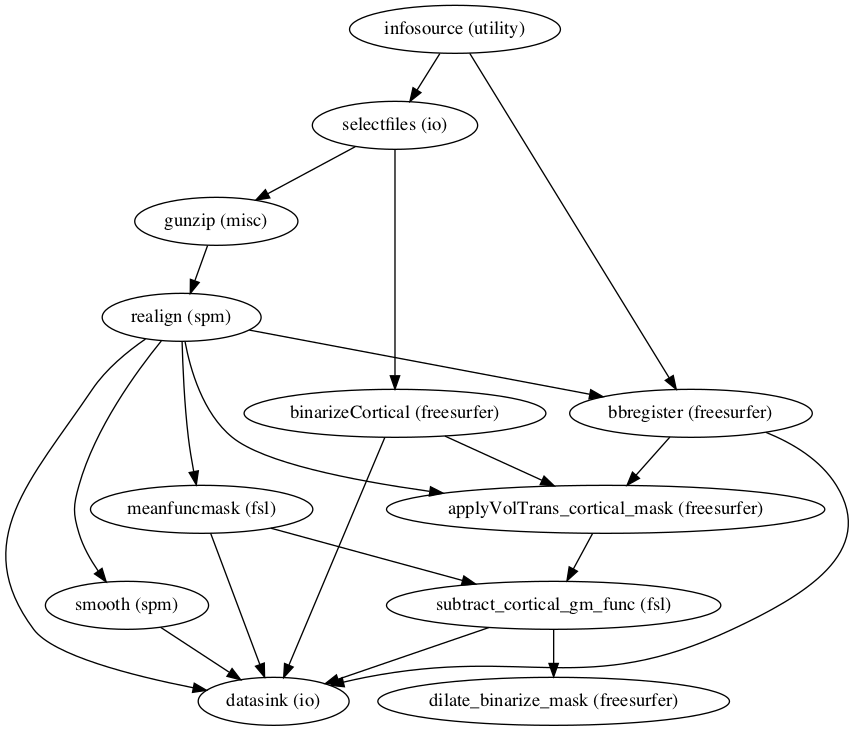

In [ ]:
from IPython.display import Image
Image(filename="/data/mvs/derivatives/preprocessing/workingdir_preprocessing/preproc_mvs/graph.png")

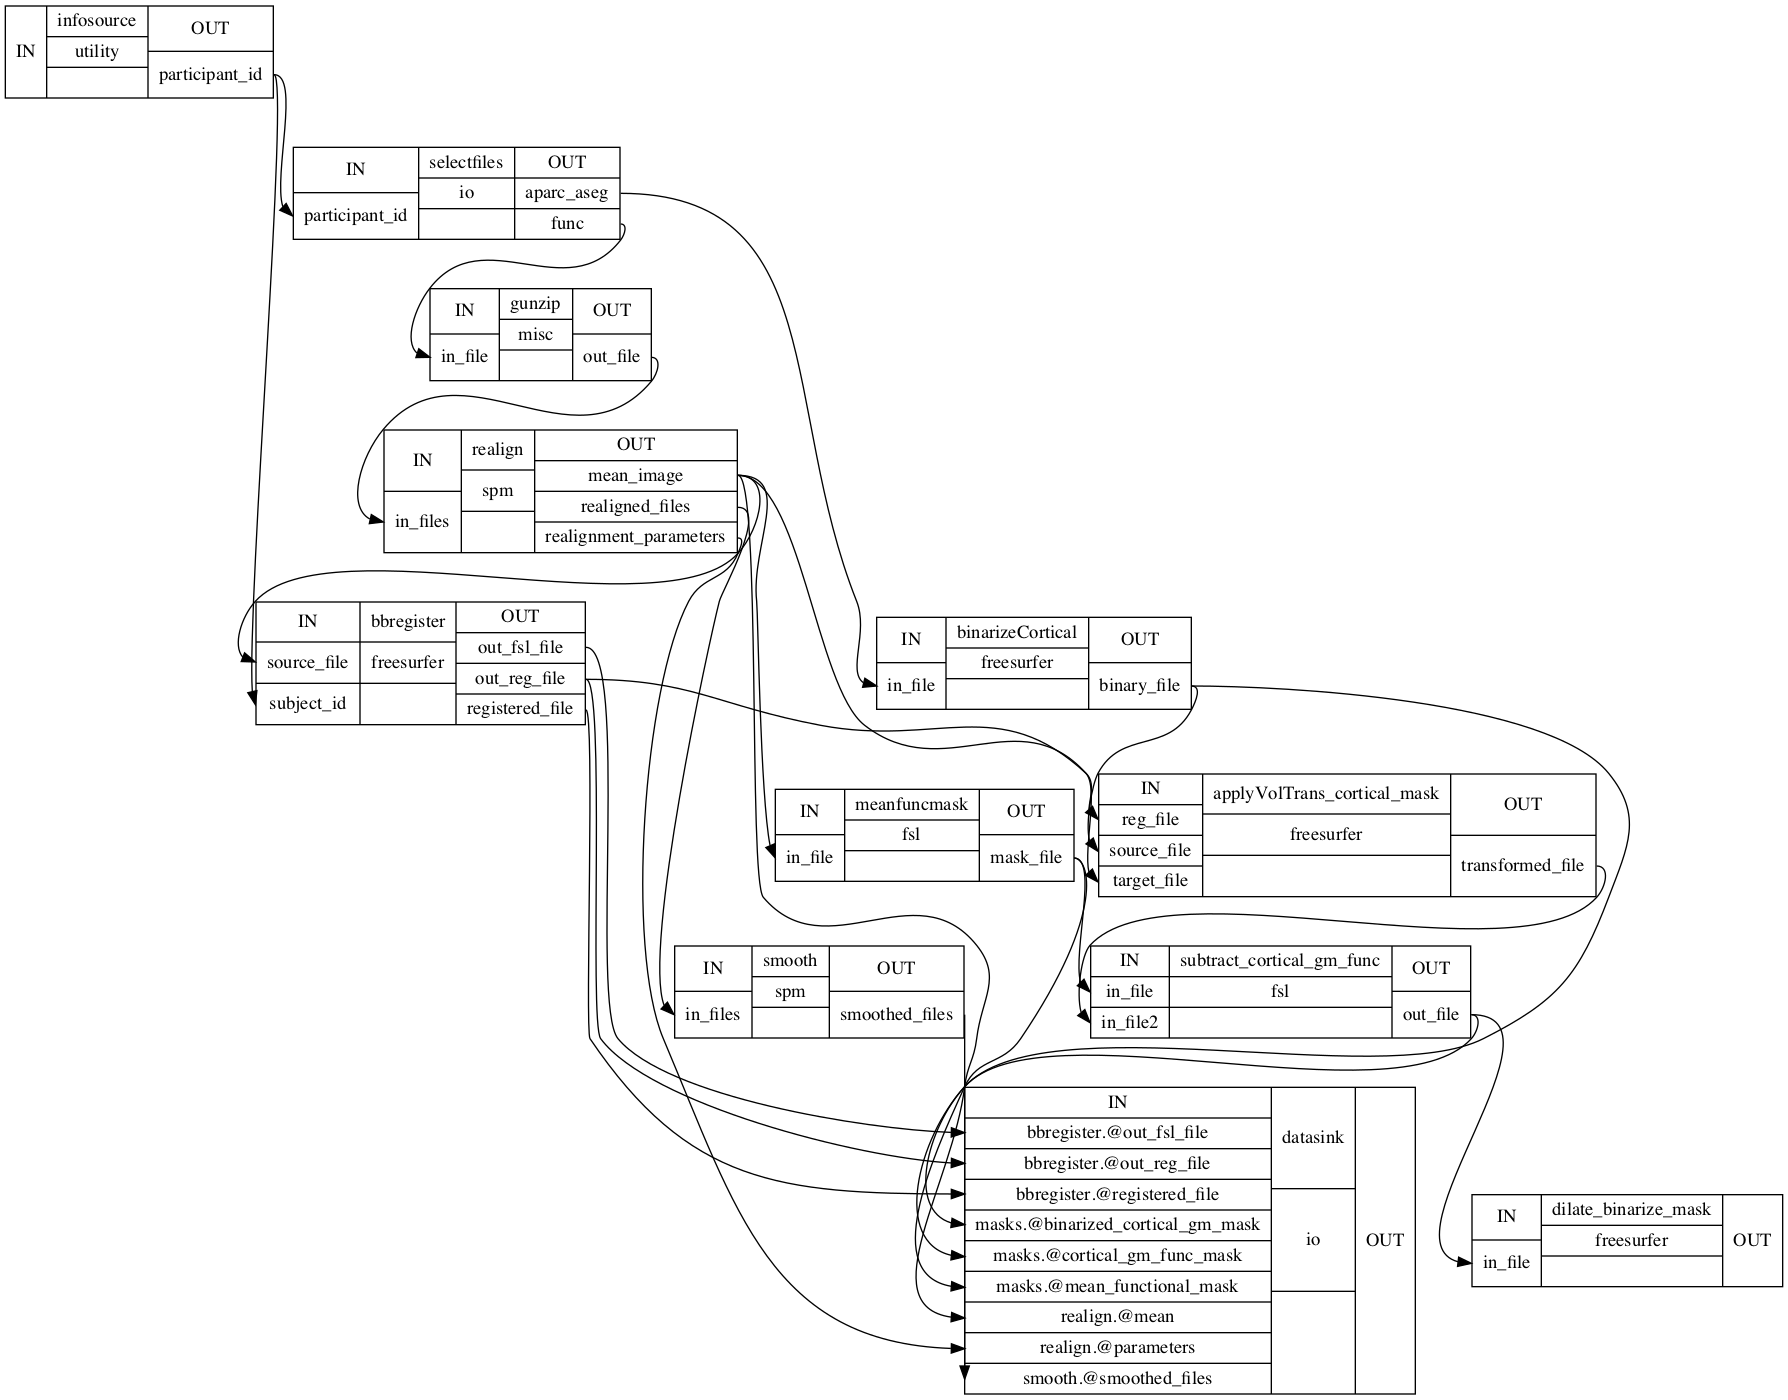

In [ ]:
Image(filename="/data/mvs/derivatives/preprocessing/workingdir_preprocessing/preproc_mvs/graph_detailed.png")

## Statistical analyses - individual level

Before we start, let's important the `modules` and `functions` we need.

### Import Modules

In [ ]:
import pandas as pd
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.interfaces.freesurfer import MRIConvert

We also need to define new `output` and `working directories` as we're in the next processing stage.

### Define and set important paths

In [ ]:
output_dir_ind_level = 'individual_statistics' 
working_dir_ind_level = 'workingdir_individual_statistics' 
experiment_dir = '/data/mvs'

### Define and set processing nodes

With our data preprocessed, we can continue to the individual level statistics. In other words, we want to the model the cortical responses to the included stimuli. Please note, that we, in contrast to most pipelines, will run the statistical analyses on the individual level in a given participant's native functional space instead of a template space. However, we will transform the resulting contrast images to a template space later on. We choose the rather "classic" approach of a mass-univariate analysis in form of a voxel-wise General Linear Model (GLM). We'll use [SPM](https://www.fil.ion.ucl.ac.uk/spm/) functionality for that as it includes an option for nicely modelling the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) in datasets with comparably fast data acquisition protocols. As the `TR` in our case was `0.529 seconds`, this appears appropriate.  This part of the analyses contained three steps: `defining a model`, `estimating the model` and `computing contrasts`.  As in the [preprocessing](), we will start with defining the necessary `nodes` and subsequently connect them within a `workflow`. We're going to start with the basic model definition through [nipype's SpecifySPMModel](https://nipype.readthedocs.io/en/latest/api/generated/nipype.algorithms.modelgen.html#specifyspmmodel). Given that we don't want to concatenate runs, we set the `concatenate_runs` parameter to `False`. Both `input` and `output units` of our model will be in seconds (`secs`). The `TR` of our paradigm was `0.529 seconds` and we choose a `high pass filter cutoff` of `128 Hz`. 

In [ ]:
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=0.529,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

The next step consists of setting up basics of the `design matrix` we want to estimate later on. We use [SPM's Level1Design function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.model.html#level1design) using the [canonical hemodynamic response function](https://andysbrainbook.readthedocs.io/en/latest/fMRI_Short_Course/Statistics/03_Stats_HRF_Overview.html) and no [derivatives](https://www.sciencedirect.com/science/article/abs/pii/S105381190300781X). As before our `timing units` are `seconds` and our `TR` was `0.529 seconds`. We set the `model_serial_correlation` parameter to `FAST` in order to address our comparably fast `TR`.

In [ ]:
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=0.529,
                                 model_serial_correlations='FAST'),
                    name="level1design")

Setting up a model is only have of the deal, we also need to actually estimate it. Here, we did that using [SPM's EstimateModel function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.model.html#estimatemodel), choosing the `classical` `estimation method`.

In [ ]:
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

From our estimated model we can compute contrasts, that is comparing the estimated responses to our stimuli against other modeled or unmodeled aspects of our paradigm. [SPM's EstimateContrast](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.model.html#estimatecontrast) comes in handy for that. 

In [ ]:
conestimate = Node(EstimateContrast(), name="conestimate")

During the [preprocessing]() we needed to [unzip](https://nipype.readthedocs.io/en/latest/api/generated/nipype.algorithms.misc.html#gunzip) our functional files as `SPM` can't read `zipped` files. However, we want to continue with `zipped` files and thus use [FreeSurfer's MRIConvert](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.freesurfer.utils.html#mrisconvert) as a [MapNode](https://nipype.readthedocs.io/en/latest/api/generated/nipype.pipeline.engine.nodes.html#nipype.pipeline.engine.nodes.MapNode) to `zip` the computed `contrast images`.  

In [ ]:
mriconvert = MapNode(MRIConvert(out_type='niigz'),
                     name='mriconvert',
                     iterfield=['in_file'])

Nice, the basics are done. Let's create a workflow and connect the `nodes`

### Create the workflow and connect nodes
As done for the [preprocessing](), we have to create an empty `workflow` and connect our `processing nodes` accordingly. The basics steps are always identical, we just have to adapt the `workflow name` and `experiment` as well as `working directory`.  

In [ ]:
ind_level = Workflow(name='ind_level')
ind_level.base_dir = opj(experiment_dir, working_dir_ind_level)

Let's connect our processing `nodes`:

In [ ]:
ind_level.connect([(modelspec, level1design, [('session_info', 'session_info')]), # send model specifiction to individual level model
                   (level1design, level1estimate, [('spm_mat_file', 'spm_mat_file')]), # estimate individual level model
                   (level1estimate, conestimate, [('spm_mat_file', 'spm_mat_file'), # send spm.mat file to contrast estimation
                                                  ('beta_images', 'beta_images'), # send beta images to contrast estimation
                                                  ('residual_image', 'residual_image')]), # send residual image to contrast estimation
                   (conestimate, mriconvert, [('con_images', 'in_file')]) # zip contrast images
                  ])

So far, we're missing one of the most crucial parts. We're interested in the responses evoked through our stimuli, however, but we didn't specify what stimuli where presented where for how long. This information can be found in the [events files](https://bids-specification.readthedocs.io/en/stable/04-modality-specific-files/05-task-events.html) that describe a given experimental run per participant. Based on our paradigm, each participant has two `event files` as two runs were presented. Within each we have the `trial type`, `onset` and `duration` for every presented stimulus. Here's an example of how they look like (note how easy and comprehensive this through [BIDS](https://bids.neuroimaging.io/) and [pandas](https://pandas.pydata.org/): 

In [ ]:
event_file_example = pd.read_table('static/sub-01_task-mvs_run-01_events.tsv')
event_file_example

trial_type    onset  duration correct
0       Music    4.710      1.87       Y
1       Music    8.726      1.76       Y
2       Music   20.776      1.68       Y
3       Music   24.792      1.76       Y
4       Music   28.809      1.57       Y
..        ...      ...       ...     ...
85      Voice  337.496      1.39       Y
86      Voice  341.513      1.97       Y
87      Voice  353.546      1.71       Y
88      Voice  357.562      1.43       Y
89      Voice  361.562      1.86       Y

[90 rows x 4 columns]

Let's check each condition separately.

In [ ]:
for condition in event_file_example.groupby('trial_type'):
    print(condition)

('Music',    trial_type    onset  duration correct
0       Music    4.710      1.87       Y
1       Music    8.726      1.76       Y
2       Music   20.776      1.68       Y
3       Music   24.792      1.76       Y
4       Music   28.809      1.57       Y
5       Music   52.874      1.45       Y
6       Music   56.874      1.76       Y
7       Music   72.923      2.00       Y
8       Music   84.940      1.85       Y
9       Music   88.939      1.76       Y
10      Music   96.956      1.80       Y
11      Music  100.956      1.65       Y
12      Music  116.972      1.70       Y
13      Music  120.972      1.83       Y
14      Music  129.005      1.67       Y
15      Music  153.087      1.65       Y
16      Music  169.103      1.88       Y
17      Music  181.136      1.72       Y
18      Music  193.185      1.52       Y
19      Music  221.268      1.69       Y
20      Music  233.300      1.60       Y
21      Music  237.300      1.90       Y
22      Music  253.333      1.71       Y
23    

We still need to extract and provide this information within our model. Luckily, [fmriflows has a great function](https://github.com/miykael/fmriflows/blob/master/notebooks/04_analysis_1st-level.ipynb) we can borrow and adapt to do so. The basic idea is that we provide `event files` and `condition names` as input and get the needed information in a so called [Bunch](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.base.support.html#nipype.interfaces.base.support.Bunch). 

In [ ]:
def collect_model_info(event_files, condition_names):

    import numpy as np
    import pandas as pd
    from nipype.interfaces.base import Bunch

    model_info = []

    for i, f in enumerate(event_files):

        trialinfo = pd.read_csv(f, sep='	')
        stimuli_list = [t for t in trialinfo.trial_type if str(t) in condition_names]
        conditions = []
        onsets = []
        durations = []

        for group in trialinfo.groupby('trial_type'):
            if str(group[0]) in condition_names:
                conditions.append(str(group[0])+'_run-0%s'%str(i+1))
                onsets.append(list(group[1].onset))
                durations.append(group[1].duration.tolist())

        model_info.append(Bunch(conditions=conditions,
                                onsets=onsets,
                                durations=durations))
   
    return model_info

In order to include this `function` in our `workflow`, we need to set up a [Function Node](https://miykael.github.io/nipype_tutorial/notebooks/basic_function_interface.html) that runs our above created `function`.

In [ ]:
get_model_info = Node(Function(input_names=['event_files', 'condition_names'],
                               output_names=['model_info'],
                               function=collect_model_info),
                      name='get_model_info')
get_model_info.inputs.condition_names = ['Music', 'Singing', 'Voice']

Another thing we need to do is defining the contrasts that should be computed after the model was estimated. To this end, we create a list of `condition` names based on our paradigm, that is `music`, `singing` and `voice` for each of two runs:

In [ ]:
condition_names = ['Music_run-01','Singing_run-01','Voice_run-01','Music_run-02','Singing_run-02', 'Voice_run-02'] 

Subsequently, we can use this information to setup the contrasts we want. Based on the planned [MVPA]() we define two types of contrasts for each `condition`: per run and across both runs. The [SPM EstimateContrast interface](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.model.html#estimatecontrast) requires a `contrast name`, `contrast type`, `condition names` and `contrast vectors`. Thus, we define this accordingly. Please note that we always define `T contrasts`.

In [ ]:
contrast01 = ['Music_run-01', 'T', condition_names, [1, 0, 0, 0, 0, 0]]
contrast02 = ['Singing_run-01', 'T', condition_names, [0, 1, 0, 0, 0, 0]]
contrast03 = ['Voice_run-01', 'T', condition_names, [0, 0, 1, 0, 0, 0]]
contrast04 = ['Music_run-02', 'T', condition_names, [0, 0, 0, 1, 0, 0]]
contrast05 = ['Singing_run-02', 'T', condition_names, [0, 0, 0, 0, 1, 0]]
contrast06 = ['Voice_run-02', 'T', condition_names, [0, 0, 0, 0, 0, 1]]
contrast07 = ['Music_both_runs', 'T', condition_names, [1, 0, 0, 1, 0, 0]]
contrast08 = ['Singing_both_runs', 'T', condition_names, [0, 1, 0, 0, 1, 0]]
contrast09 = ['Voice_both_runs', 'T', condition_names, [0, 0, 1, 0, 0, 1]]

All that's left to do at this stage is to define a list of contrasts that we'll later pass to our [EstimateContrast node](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.model.html#estimatecontrast).

In [ ]:
contrast_list = [contrast01, contrast02, contrast03, contrast04, contrast05, contrast06, contrast07, contrast08, contrast09]

Comparable to the [preprocessing]() we need to set up `input` and `output streams`, i.e. providing our `workflow` with data and indicating where it should be saved. We're going to use the [IndentityInterface](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.utility.base.html#nipype-interfaces-utility-base-identityinterface), [SelectFiles](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#selectfiles) and [DataSink](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#datasink) functions again. Again, the [IdentityInterface](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.utility.base.html#nipype-interfaces-utility-base-identityinterface) needs the `participant_list` to iterate over, but now we also indicate the `contrast_list` to pass that information to the [EstimateContrast](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.model.html#estimatecontrast) node.

In [ ]:
infosource = Node(IdentityInterface(fields=['participant_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('participant_id', participant_list)]

To make [SelectFiles](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#selectfiles) work, we need to define `template paths` to the data we need. At this point of the processing pipeline this includes the `preprocessed (smoothed) functional images`, the `realignment parameters`,`event files`  and the `cortical gray matter mask`.

In [ ]:
templates = {'func_smooth': 'derivatives/preprocessing/smooth/{participant_id}/*.nii',
             'realign_par': 'derivatives/preprocessing/realign/{participant_id}/rp*.txt',
             'event_files': '{participant_id}/func/*.tsv',
             'mask': 'derivatives/preprocessing/masks/{participant_id}/*.nii'}


Let's define the node via setting the `templates` and `base_directory`.

In [ ]:
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir),
                   name="selectfiles")

On the other side of the `workflow` we need define our output structure through [DataSink](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#datasink). As usual this needs the `base_directory` and the `container`, i.e. `output directory`. 

In [ ]:
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir_ind_level),
                name="datasink")

And we want to `substitute` some parts of the file names to make it more readable. 

In [ ]:
substitutions = [('_subject_id_', '_')]
datasink.inputs.substitutions = substitutions

It's time to connect the `nodes` again, this time the `input` and `outputs` to the `processing nodes`.

In [ ]:
ind_level.connect([(infosource, selectfiles, [('participant_id', 'participant_id')]), # collect files from participants
                  (selectfiles, modelspec,[('func_smooth', 'functional_runs')]),  # provide model specification with smoothed images
                  (selectfiles, modelspec,[('realign_par', 'realignment_parameters')]), # provide model specification with realignment parameters
                  (selectfiles, level1design, [('mask', 'mask_image')]), # provide model specification with cortical gray matter mask in functional space 
                  (selectfiles, get_model_info, [('event_files', 'event_files')]), # extract experiment information 
                  (get_model_info, modelspec, [('model_info', 'subject_info')]), # provide model specification with experiment information
                  (infosource, conestimate, [('contrasts', 'contrasts')]), # indicate list of contrasts to be computed  
                  (mriconvert, datasink, [('out_file', 'contrasts.@contrasts')]), # send zipped contrast imags to datasink
                  (conestimate, datasink, [('spm_mat_file', 'contrasts.@spm_mat'), # send spm.mat file to datasink
                                          ('spmT_images', 'contrasts.@T'), # send spm t images to datasink
                                          ('con_images', 'contrasts.@con')]), # send contrast images to datasink
                  ])

### Evaluate the workflow

As done during [preprocessing](), we will evaluate our `workflow` by generating graphs that visualize the `inputs` and `outputs` of our `nodes`.  

In [ ]:
ind_level.write_graph(graph2use='colored',format='png', simple_form=True)


ind_level.write_graph(graph2use='flat',format='png', simple_form=True)

'/data/mvs/derivatives/individual_level/workingdir_individual_statistics/ind_level/graph.png'

Let's check them:

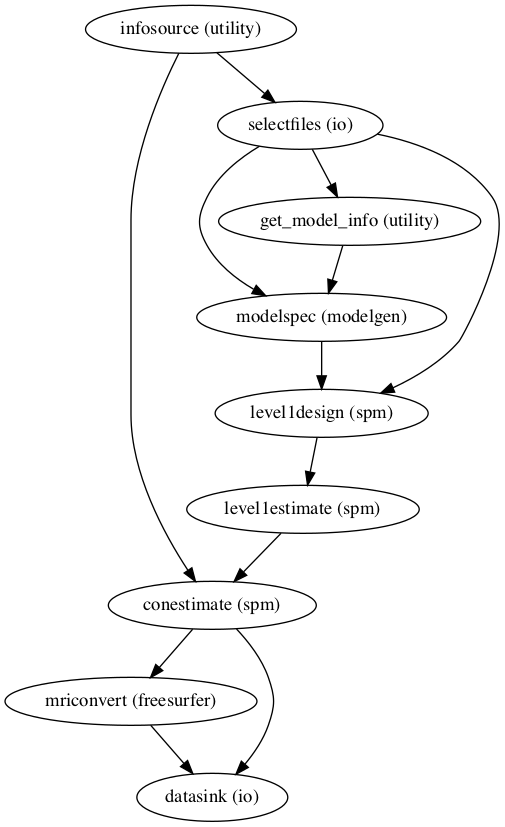

In [ ]:
from IPython.display import Image
Image(filename="/data/mvs/derivatives/individual_level/workingdir_individual_statistics/ind_level/graph.png")

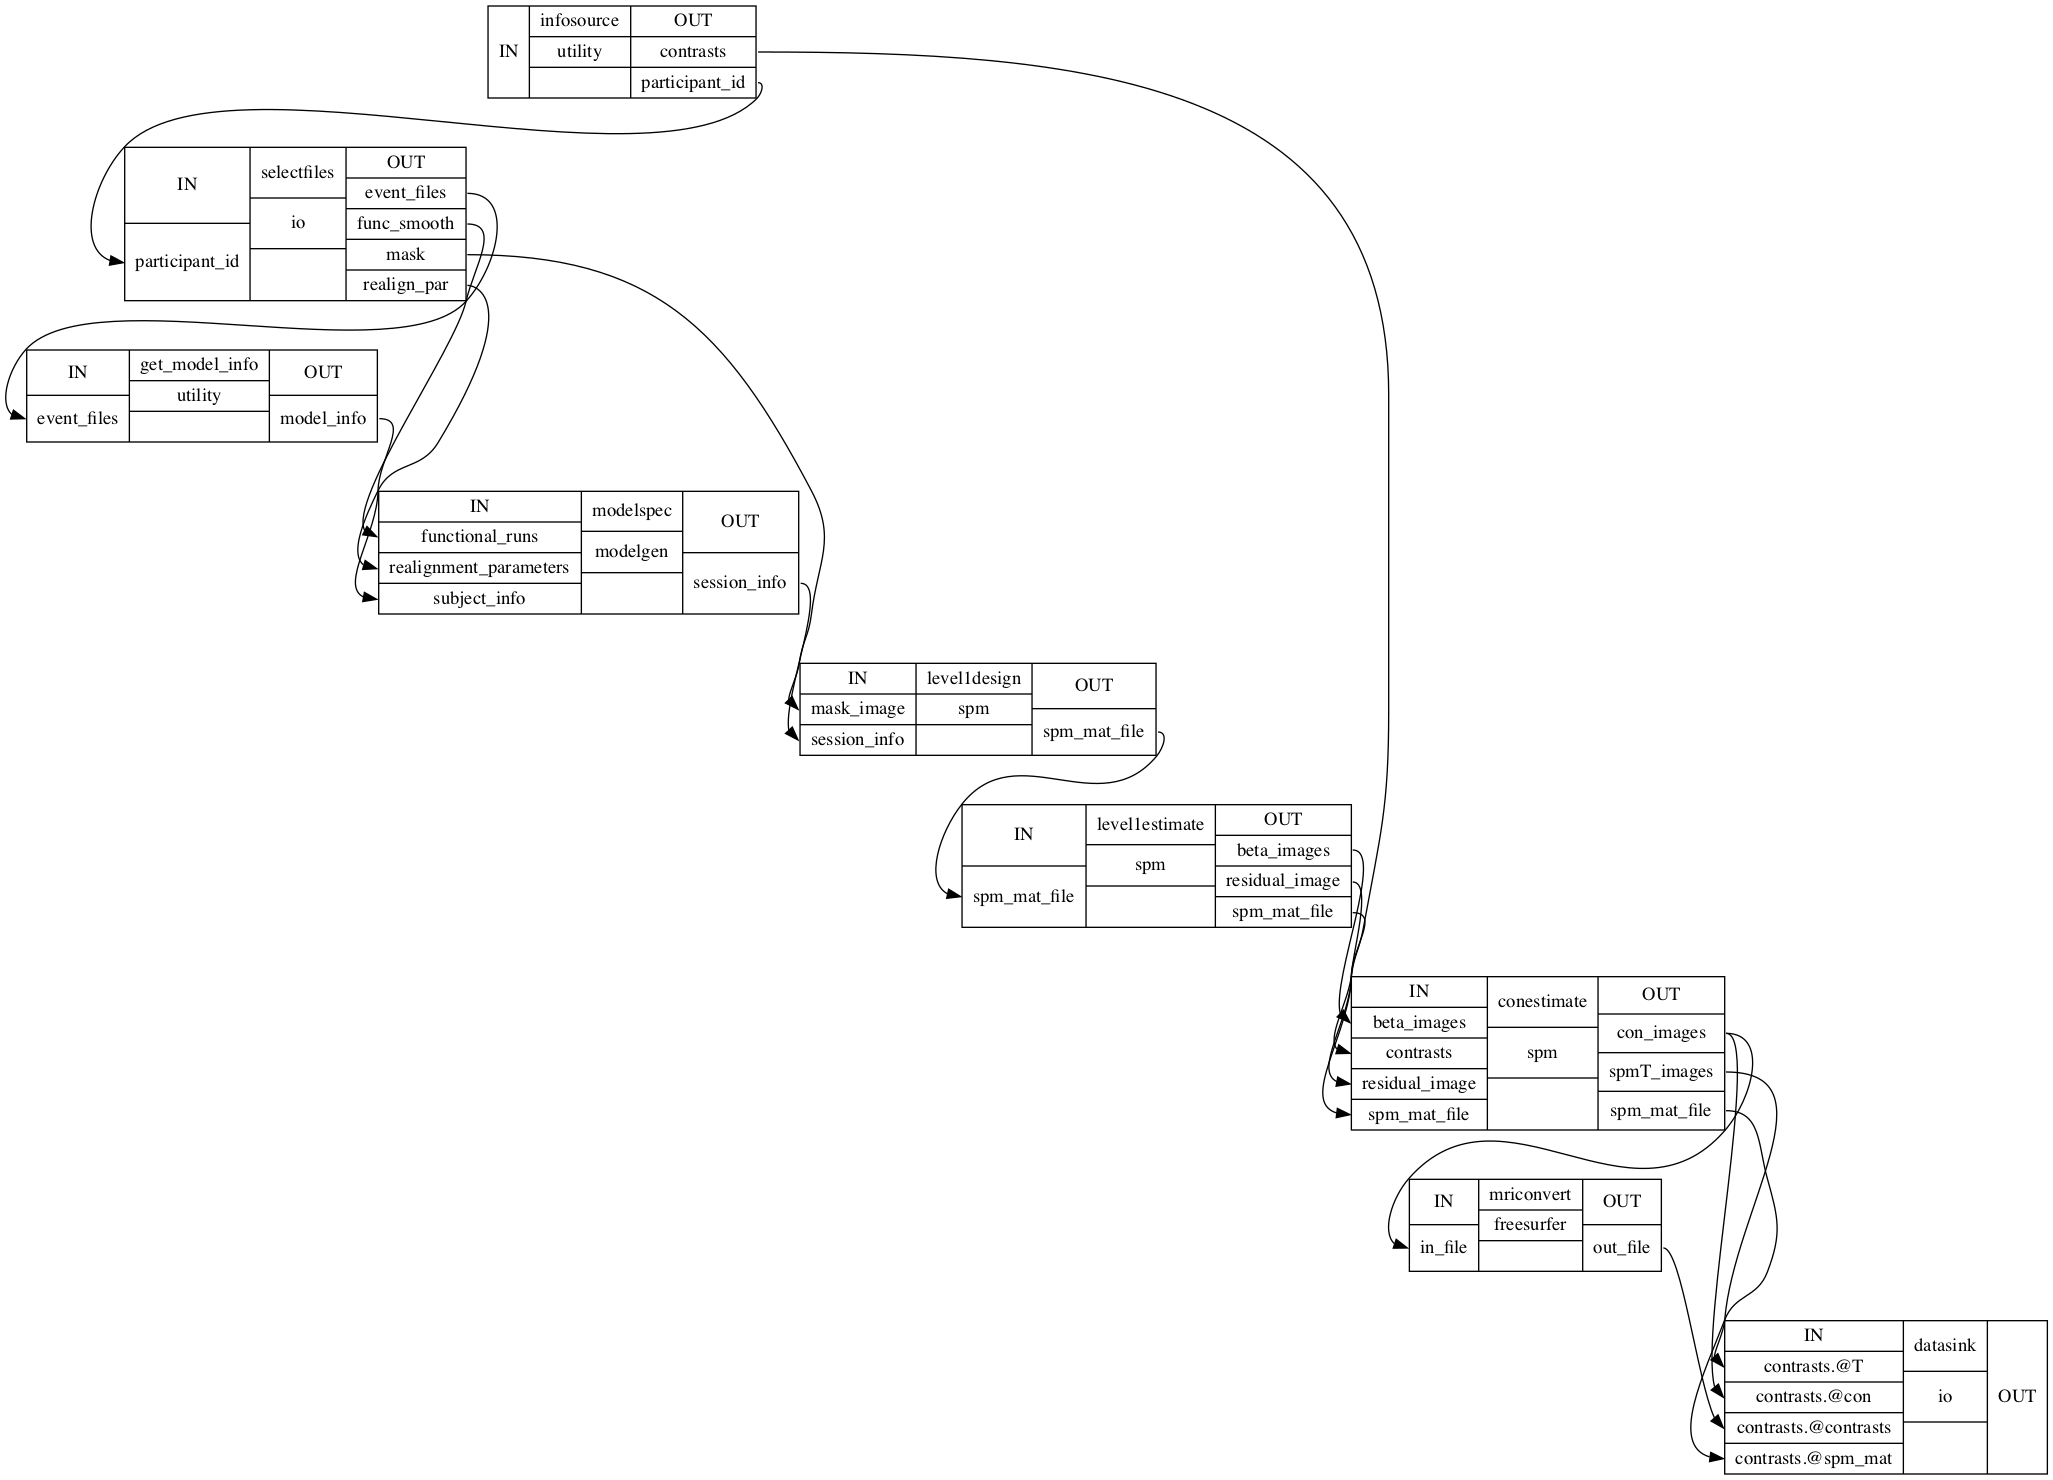

In [ ]:
Image('/data/mvs/derivatives/individual_level/workingdir_individual_statistics/ind_level/graph_detailed.png')


## Native space - template space registration

As usual, let's important necessary `modules` and `functions` before we start.

### Import Modules

In [ ]:
from nipype.interfaces.ants import Registration
from nipype.interfaces.fsl import Info

### Define and set important paths

You know the drill, new processing stage, new `output` and `working directory` path.

In [ ]:
output_dir = 'derivatives/registration' 
working_dir = 'derivatives/registration/workingdir' 

### Define and set processing nodes

Now that we have our contrast images that contain the cortical responses evoked through our stimuli, we can start the process of bringing them in a shared template space. For the majority of `group level` analyses, this is a necessity and even though we won't do a "classic" `mass-univariate group level` analyses, we still need it for the planned [MVPA](). We want to achieve the transformation from `native functional` to `template space` via a two-step procedure: `native functional` -> `native anatomical` -> `template`. As we have `contrast images` in a given participants native space and already computed the coregistration between `functional` and `anatomical space` for each participant, we're only missing the coregistration between a given participants `native anatomical space` and the `template space`. We're going to use the fantastic [ANTs software](http://stnava.github.io/ANTs/) for that, more specifically it's [Registration function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.ants.html#registration). 

In [ ]:
antsreg = Node(Registration(args='--float',
                            collapse_output_transforms=True,
                            fixed_image=template,
                            initial_moving_transform_com=True,
                            num_threads=1,
                            output_inverse_warped_image=True,
                            output_warped_image=True,
                            sigma_units=['vox']*3,
                            transforms=['Rigid', 'Affine', 'SyN'],
                            terminal_output='file',
                            winsorize_lower_quantile=0.005,
                            winsorize_upper_quantile=0.995,
                            convergence_threshold=[1e-06],
                            convergence_window_size=[10],
                            metric=['MI', 'MI', 'CC'],
                            metric_weight=[1.0]*3,
                            number_of_iterations=[[1000, 500, 250, 100],
                                                  [1000, 500, 250, 100],
                                                  [100, 70, 50, 20]],
                            radius_or_number_of_bins=[32, 32, 4],
                            sampling_percentage=[0.25, 0.25, 1],
                            sampling_strategy=['Regular',
                                               'Regular',
                                               'None'],
                            shrink_factors=[[8, 4, 2, 1]]*3,
                            smoothing_sigmas=[[3, 2, 1, 0]]*3,
                            transform_parameters=[(0.1,),
                                                  (0.1,),
                                                  (0.1, 3.0, 0.0)],
                            use_histogram_matching=True,
                            write_composite_transform=True),
               name='antsreg')

We decided to go with the [MNI152 template in its non-linear symmetric version](http://nist.mni.mcgill.ca/?p=858) given its frequent and established usage, particularly its support in other higher level toolboxes/resources (e.g. [neuorsynth](https://www.neurosynth.org/)). Through [nipype's FSL interface](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.html), i.e. the [Info function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.base.html#nipype.interfaces.fsl.base.Info), we can easily gather the template.

In [ ]:
template = Info.standard_image('MNI152_T1_1mm_brain.nii.gz')

And check it out using [nilearn](http://nilearn.github.io/modules/generated/nilearn.plotting.view_img.html#nilearn.plotting.view_img) (it's interactive, you can scroll through the `template image`!).


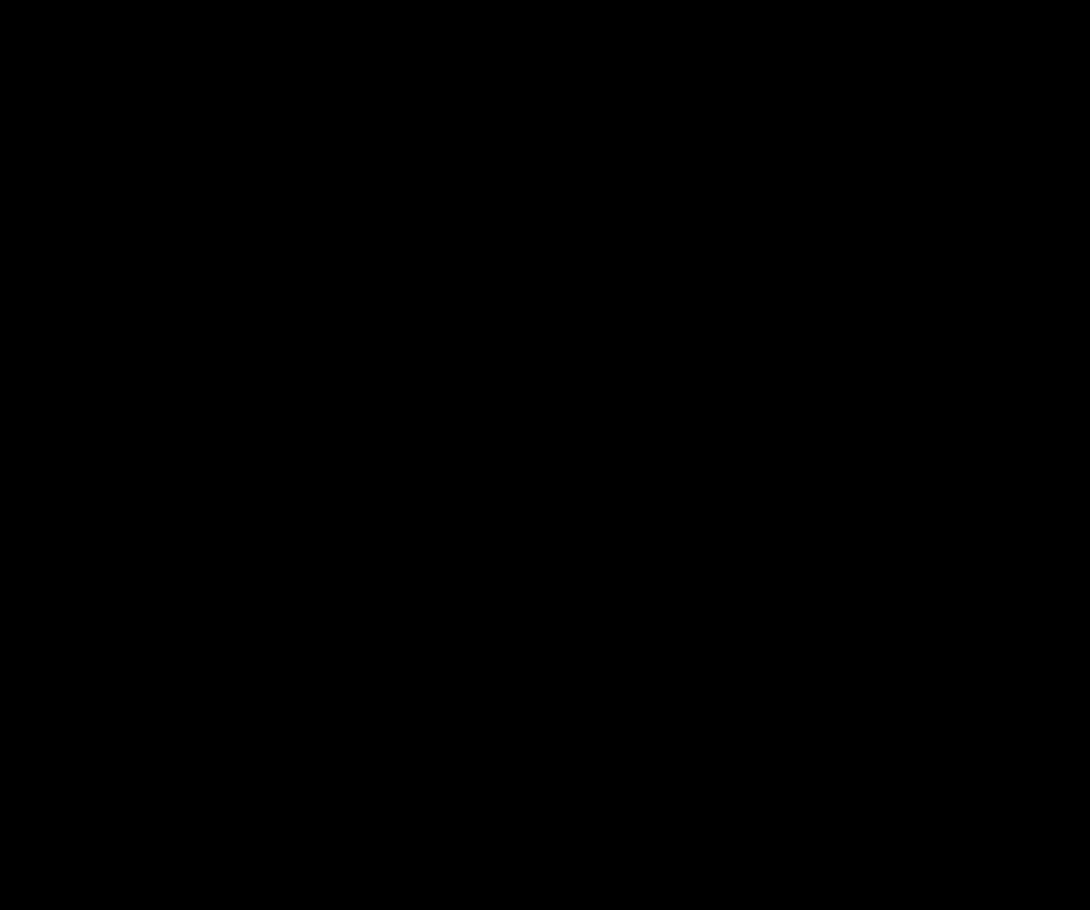
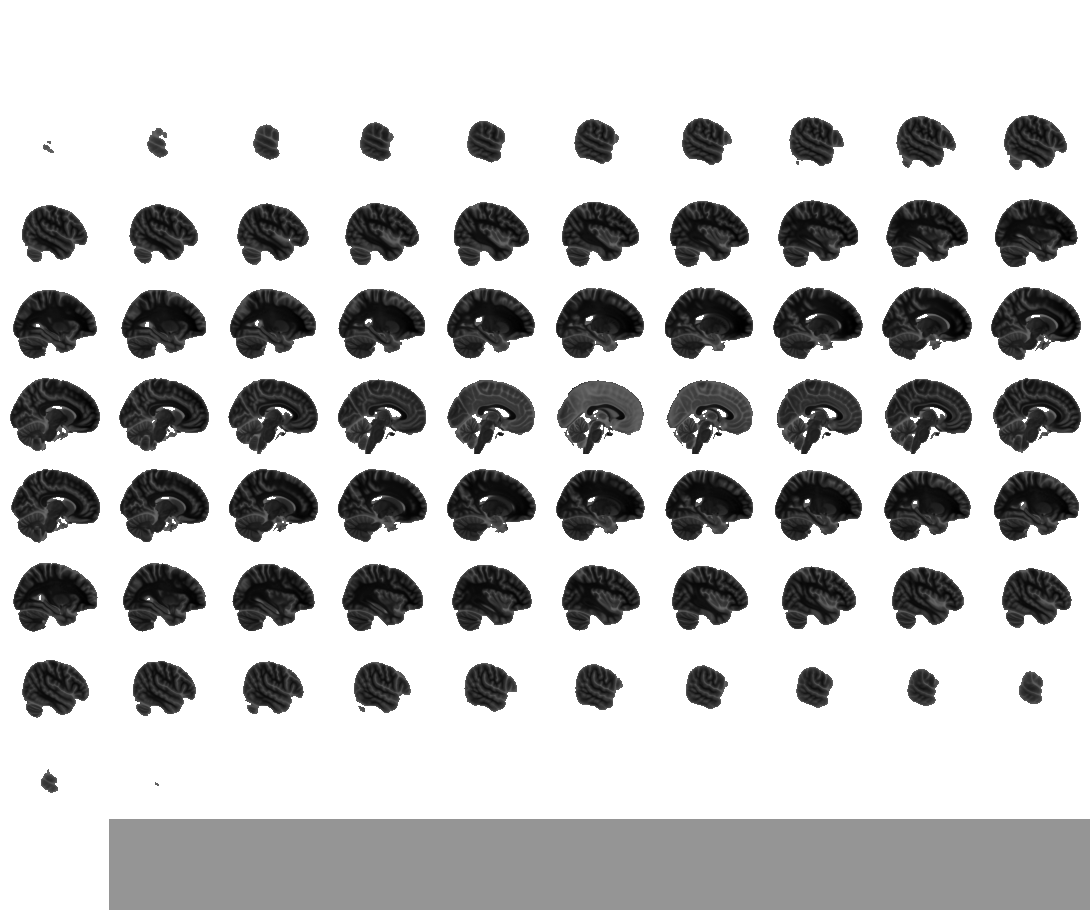

In [ ]:
from nilearn.plotting import view_img
view_img(template, cmap='Greys', draw_cross=False, colorbar=False, dim=-2)

Fancy, let's set it as `fixed_image` within our `Registration` node, that is defining it as the `image` the `moving image` (`anatomical image`) should be coregistered to.

In [ ]:
antsreg.inputs.fixed_image=template

### Create the workflow and connect the nodes
As this is basically a `one processing node workflow` we can already create the empty `workflow` and set `input` and `output streams`. First things first, the `workflow`.

In [ ]:
coreg_ANTs = Workflow(name='coreg_ANTs')
coreg_ANTs.base_dir = opj(experiment_dir, working_dir)

Hello [IdentityInterface funcion](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.utility.base.html#nipype-interfaces-utility-base-identityinterface) my old friend...

In [ ]:
infosource = Node(IdentityInterface(fields=['participant_id']),
                  name="infosource")
infosource.iterables = [('participant_id', participant_list)]

Given that the `template` is already defined, we only need to provide the path for the `anatomical images` within the `templat paths` of the [SelectFiles function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#selectfiles).

In [ ]:
templates = {'anat': '/data/mvs/derivatives/mindboggle/freesurfer/{subject_id}/mri/brain.mgz',
             }

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir),
                   name="selectfiles")

The `output` is handled by the [DataSink function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#datasink) again.

In [ ]:
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

No `DataSink` without `substitutions`. 

In [ ]:
substitutions = [('_participant_id_', '')]
datasink.inputs.substitutions = substitutions

Connecting the `nodes` is done in no time for this processing stage:  

In [ ]:
coreg_ANTs.connect([(infosource, selectfiles, [('participant_id', 'participant_id')]), # select files from participants
                    (selectfiles, antsreg, [('anat', 'moving_image')]), # set anatomical image as moving image
                    (antsreg, datasink, [('warped_image', 'antsreg.@warped_image'), # send transformed image to datasink
                                         ('inverse_warped_image', 'antsreg.@inverse_warped_image'), # send inverse transformed image to datasink
                                         ('composite_transform', 'antsreg.@transform'), # send transformation matrices to datasink
                                         ('inverse_composite_transform', 'antsreg.@inverse_transform')]), # send inverse transformation matrices to datasink
                  ])

### Evaluate the workflow

Using the same functions as for the [preprocessing]() and [individual level statistics]() we can visualize the `workflow`: 

In [ ]:
coreg_ANTs.write_graph(graph2use='colored',format='png', simple_form=True)


coreg_ANTs.write_graph(graph2use='flat',format='png', simple_form=True)

'/data/mvs/derivatives/registration/workingdir/coreg_ANTs/graph.png'

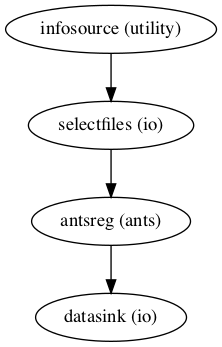

In [ ]:
from IPython.display import Image
Image(filename="/data/mvs/derivatives/registration/workingdir/coreg_ANTs/graph.png")

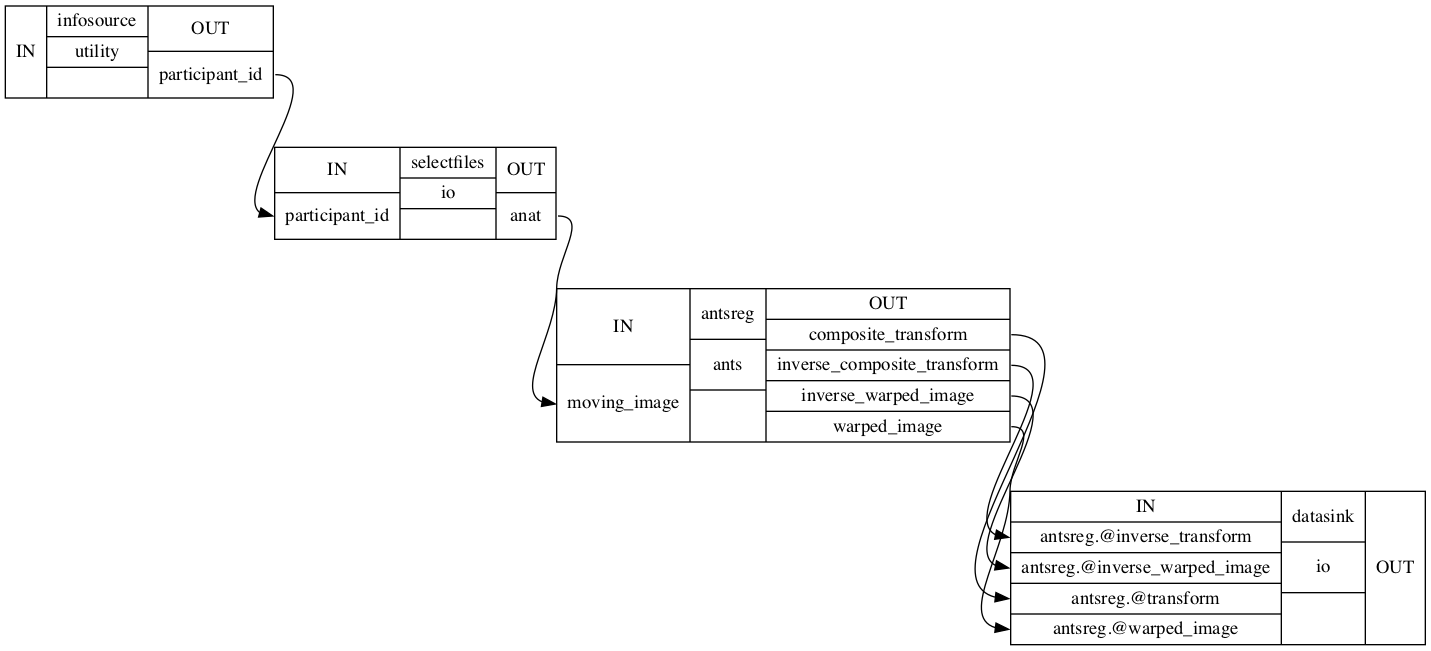

In [ ]:
Image(filename="/data/mvs/derivatives/registration/workingdir/coreg_ANTs/graph_detailed.png")

## Native space to template space transformation

Now that we have our contrast images in `participant specific functional space` that contain the cortical responses evoked through our stimuli, we can start the process of bringing them in a shared template space. For the majority of `group level` analyses, this is a necessity and even though we won't do a "classic" `mass-univariate group level` analyses, we still need it for the planned [MVPA](). We want to achieve the transformation from `native functional` to `template space` via a two-step procedure: `native functional` -> `native anatomical` -> `template`. As we have `contrast images` in a given participants native space and already computed the coregistration between `functional` and `anatomical space`, as well as `snatomical` and `template space` for each participant, we only need to concatenate the respective transformation matrices and apply them to the `images`. As we want to use `ANTs` for the `transformation`, we need to convert the `transformation matrix` obtained through `bbregister` to [ITK](https://itk.org/Wiki/ITK) format. We'll do this via the [C3DAffineTool](https://pythonhosted.org/nipype/interfaces/generated/nipype.interfaces.c3.html#c3daffinetool). 

### Import modules
Let's import the `modules` and `functions` we need for this step.

In [ ]:
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.c3 import C3dAffineTool
from nipype.interfaces.utility.base import Merge

### Define and set important paths and variables
As we need a few files from previous processing steps, we set a set of paths, including the `preprocessing`, `individual level statistics` and `registration` folders. 

In [ ]:
input_dir_individual_level = '/data/mvs/derivatives/individual_level'     
input_dir_reg = '/data/mvs/derivatives/registration'
input_dir_preproc = '/data/mvs/derivatives/preprocessing'

The `output` and `working directory` are defined as usual. 

In [ ]:
output_dir = '/data/mvs/derivatives/transformation_functional' 
working_dir = '/data/derivatives/transformation_functional/workingdir' 

### Define and set processing nodes
As outlined above, some steps are needed to achieve our goal. More precisely, we need the [C3DAffineTool](https://pythonhosted.org/nipype/interfaces/generated/nipype.interfaces.c3.html#c3daffinetool), [Nipype's Merge function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.utility.base.html#merge) and [ANTs' ApplyTransforms function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.ants.html#applytransforms). The first is necessary, as `ANTs` likes the [ITK format](https://itk.org/Wiki/ITK) and thus we need to convert the `FSL registration file` obtained during the `coregistration step` of the [preprocessing]() accordingly. To do so, the function needs all inputs of the original `coregistration` function, as well as the computed `registration matrix`. Those parts will be set within the `workflow`. Here we'll only create the node and set `conversion specific information`, i.e. that an `FSL registration matrix` will be used and that we want to obtain an `ITK format`.  

In [ ]:
convert2itk = Node(C3dAffineTool(fsl2ras=True,
                                 itk_transform=True),
                   name='convert2itk')

In order to avoid multiple `transformations` of the same `image`, we want to concatenate our `registration matrices` (from `functional` to `anatomical space` and from `anatomical` to `template space`. That's easily done using [Nipype's Merge function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.utility.base.html#merge). We indicate that we want to concatenate `2` inputs into one list.

In [ ]:
merge = Node(Merge(2), name='merge')

Now to the actual `transformation` which we will be running through [ANTs' ApplyTransforms function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.ants.html#applytransforms). Comparably to the registration, [ANTs](http://stnava.github.io/ANTs/) is more complex than other software packages (which IMHO is a good thing). There are a lot of `input parameters` we can set, so let's go through them step by step. Starting easy, our `reference image` is already set through the same `template` we used during the `anatomical` to `template space` [coregistration](). Through `args=='--float'` we indicate that we want to use `floats` instead of `double` for computation. We set `input_image_type` to `3` as we don't have `vector` or `tensor`, but `time series` images. Next, we define a `linear interpolation` and that we don't want to `invert` our `transformation matrices`. To not stress our machine too much, we will run the transformation on `1 thread`. Finally, as we want to `transform multiple` images, we set the `input_image` as an `interfield`.      

In [ ]:
warpall = MapNode(ApplyTransforms(args='--float',
                                  input_image_type=3,
                                  interpolation='Linear',
                                  invert_transform_flags=[False, False],
                                  num_threads=1,
                                  reference_image=template,
                                  terminal_output='file'),
                  name='warpall', iterfield=['input_image'])

We are also going to `transform` the `mean functional image` as a sanity check via defining the same node as before, but with a different name.

In [ ]:
warpmean = Node(ApplyTransforms(args='--float',
                                input_image_type=3,
                                interpolation='Linear',
                                invert_transform_flags=[False, False],
                                num_threads=1,
                                reference_image=template,
                                terminal_output='file'),
                name='warpmean')

### Create the workflow and connect the nodes
With all `processing nodes` set, we can create our `transformation workflow` and connect the `nodes`. The classic: the `workflow` first.

In [ ]:
norm_ANTS_flow = Workflow(name='norm_ANTS_flow')
norm_ANTS_flow.base_dir = opj(experiment_dir, working_dir)

And now to the `nodes`. Please note, that we only need to connect the `merge` and `transformation nodes` at this point, as the other `nodes` will be connected within the `input` streams.

In [ ]:
norm_ANTS_flow.connect([(merge, warpmean, [('out', 'transforms')]), # provide concatenated transformation matrices for contrast image transformation
                        (merge, warpall, [('out', 'transforms')]), # provide concatenated transformation matrices for mean functional image transformation
                      ])

The `IdentityInterface` is back once more to help us define our `input stream` and as before we set the `participant_list` as `input` to `iterate` over.

In [ ]:
infosource = Node(IdentityInterface(fields=['participant_id']),
                  name="infosource")
infosource.iterables = [('participant_id', participant_list)]

Now to the templates for the [SelectFiles function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#selectfiles). As mentioned above, we need a few for this step: the `mean functional image` from the `realignment step` of the [preporcessing](), the `skull-stripped anatomical image` from the `FreeSurfer recon-all` pipeline within the [structural preprocessing step](),  the `registration matrix` from the `coregistration step` of the [preprocessing](), the `registration matrix` from the [anatomical to template registration]() and the `contrast images` from the [individual level statistical analyses](). 

In [ ]:
templates = {'reg_file' : opj(input_dir_reg, 'bbregister', '{subject_id}', 'mean*.mat'),
             'transform_composite' : opj(input_dir_reg, 'antsreg', '{subject_id}', 'transformComposite.h5'),
             'func_orig': opj(input_dir_individual_level, 'contrasts','{subject_id}', 'con*.nii'),
             'anat': '/data/mvs/derivatives/mindboggle/freesurfer/{subject_id}/mri/brain.mgz',
             'mean': opj(input_dir_preproc, 'realign', '{subject_id}', 'mean*.nii'),
             }

And the [SelectFiles function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#selectfiles) itself, with the defined `templates` and the `experiment directory` as `base directory`.

In [ ]:
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir),
                   name="selectfiles")

Identical to the other processing steps, we will use [DataSink](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#datasink) to set our `output streams` and define `substitutions`.

In [ ]:
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

substitutions = [('_subject_id_', ''),
                 ('_apply2con', ''),
                 ('_warpall', '')]
datasink.inputs.substitutions = substitutions

Ready, set, connect `nodes`. 

In [ ]:
norm_ANTS_flow.connect([(infosource, selectfiles, [('participant_id', 'participant_id')]), # select files from participants
                        (selectfiles, convert2itk, [('anat', 'reference_file')]), # set anatomical image as reference file
                        (selectfiles, convert2itk, [('mean', 'source_file')]), # set mean functional image as source file
                        (selectfiles, convert2itk, [('reg_file', 'transform_file')]), # set registration file as transform file
                        (convert2itk, merge, [('itk_transform', 'in1')]), # set transformation matrix in ITK format (function to anatomical) as first transformation
                        (selectfiles, merge, [('transform_composite', 'in2')]), # set ants tranformation matrix (anatomical to template) as second transformation
                        (selectfiles, warpall, [('func_orig', 'input_image')]), # transform contrast images to template space
                        (selectfiles, warpmean, [('mean', 'input_image')]), # transform mean functional image to template space
                        (warpall, datasink, [('output_image', 'warp_complete.@warpall')]), # send transformed contrast images to datasink
                        (warpmean, datasink, [('output_image', 'warp_complete.@warpmean')]), # send transformed mean functional image to datasink
                      ])

For the last time in this overarching processing step, we're going to evaluate the `workflow` by visualizing it in two ways: a simple and a detailed graph.

In [ ]:
norm_ANTS_flow.write_graph(graph2use='colored',format='png', simple_form=True)

norm_ANTS_flow.write_graph(graph2use='flat',format='png', simple_form=True)

'/data/mvs/derivatives/transformation_functional/workingdir/norm_ANTS_flow/graph.png'

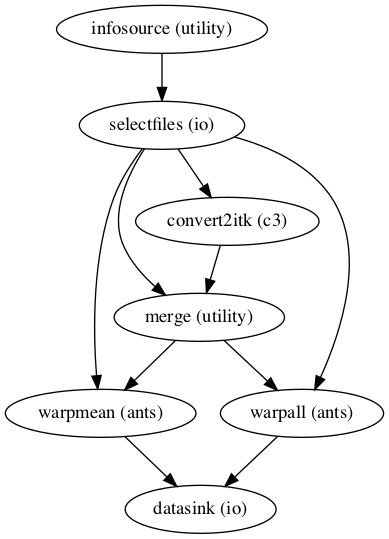

In [ ]:
from IPython.display import Image
Image(filename="/data/mvs/derivatives/transformation_functional/workingdir/norm_ANTS_flow/graph.png")

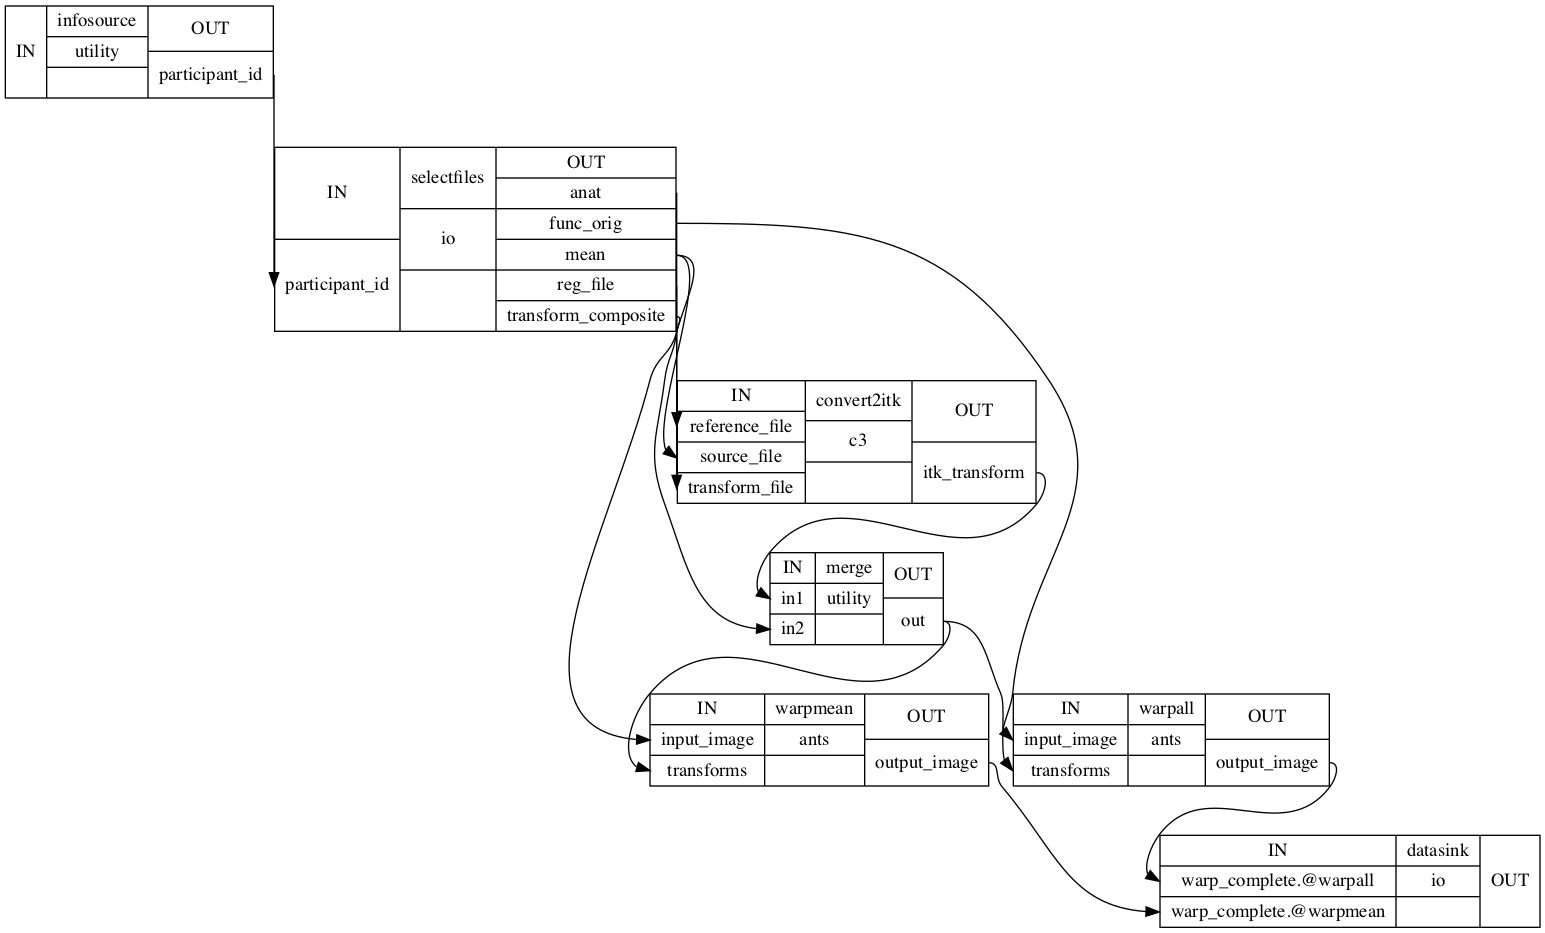

In [ ]:
Image(filename="/data/mvs/derivatives/transformation_functional/workingdir/norm_ANTS_flow/graph_detailed.png")

## Summary and outlook
Well, that was quite a ride, eh? As a lot happened since we started, let's briefly summarize everything and peak into what follows. The above processing steps and corresponding `code`/`workflows` depict the conducted analyses, including [structural]() and [functional preprocessing](), [individual level statistics](), [native to template space registration]() and [native to template space transformation](). Everything was implemented in [nipype](https://nipype.readthedocs.io/en/latest/index.html) [workflows](https://nipype.readthedocs.io/en/latest/api/generated/nipype.pipeline.engine.workflows.html) and throughout the steps we used a broad range of software packages consisting of [SPM](https://www.fil.ion.ucl.ac.uk/spm/), [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/), [FreeSurfer](http://surfer.nmr.mgh.harvard.edu/) and [ANTs](http://stnava.github.io/ANTs/). Our goal was to prepare the acquired data for subsequent analyses, especially [MVPA](). The outcomes of the steps shown here were further employed in other steps of our analysis and are referred to respectively.  Please note, that we conducted a different [individual level statistical analyses]() within the [connectivity analyses]() as we needed a different model. The next section will be provide details on the utilized [auditory cortex model]().